### Computing connectivity for resting state default mode network (manual coordinates)

In [11]:
from nilearn import input_data
from os import listdir
from nilearn import image
import numpy as np
import matplotlib.pyplot as plt
from nilearn.connectome import ConnectivityMeasure
from nilearn.plotting import plot_connectome
import pandas as pd
from itertools import combinations
from scipy.signal import hilbert

### extracting all the available subject ids in data folder

In [22]:
fmri_path = '/Users/giovanni/Documents/Datasets/LEMON/neuro/MNI2mm/'
conf_path = '/Users/giovanni/Documents/Datasets/LEMON/neuro/confounds/'


sbj_list= [x.split('_')[0] for x in listdir(fmri_path) if x.split('_')[0] != '.DS']
len(sbj_list)

107

### defining network coordinates based on MNI atlas
#### useful online tool to convert brain areas to MNI coordinates: https://bioimagesuiteweb.github.io/webapp/mni2tal.html

In [3]:
dmn_coords = {'PCC':(0, -52, 18), # Posterior Cingulate Cortex
              'LTJ':(-46, -68, 32), # Left Temporoparietal junction
              'RTJ':(46, -68, 32), # Right Temporoparietal junction
              'MPC':(1, 50, -5)} # Medial prefrontal cortex


# thr_coords = {'LAMY': (-24, 0, -21), # Left amygdala
#               'RAMY': (-21, -1, 22), # Right amygdala
#               'LACC': (-5, 39, 20), # Left dorsal antirior cingulate
#               'RACC': (6, 33, 16)} # Right dorsal antirior cingulate

thr_coords = {'LAMY': (-24, 0, -21), # Left amygdala
              'RAMY': (-21, -1, 22), # Right amygdala
              'LACC': (-5, 39, 20)} # Right dorsal antirior cingulate

### defining a few wrapper functions to extract amplitude and connectivtiy features

In [4]:
def get_network_masker(network_coords):

    net_xyz = list(network_coords.values())
    net_lbl = list(network_coords.keys())

    masker = input_data.NiftiSpheresMasker(
        net_xyz, radius=20,
        detrend=True, standardize=False,
        low_pass=0.1, high_pass=0.01, t_r=2,
        memory='nilearn_cache', memory_level=1, verbose=0)
    
    return masker, net_lbl


def flatten_conn_df(corr_mat, labels):
    
    corr_df = pd.DataFrame(corr_mat, columns=labels, index=labels)
    lbl_pairs = list(combinations(labels,2))
    
    corr_df_flat = {}
    for lbl in lbl_pairs:
        corr_df_flat[lbl[0]+'_'+lbl[1]] = [corr_df[lbl[0]][lbl[1]]]

    return pd.DataFrame(corr_df_flat)


def extract_functional_conn(time_series, conn_type='correlation'):
    
    connectivity_measure = ConnectivityMeasure(kind=conn_type)
    correlation_matrix = connectivity_measure.fit_transform([time_series])[0]
    
    return correlation_matrix


def extract_fconn_features(time_series, labels, net_name, conn_type='correlation'):

    f_conn_mat = extract_functional_conn(time_series, conn_type = conn_type)

    mat_mask = np.ones(f_conn_mat.shape) - np.eye(f_conn_mat.shape[0])
    f_conn_mean = np.mean(f_conn_mat*mat_mask)
    f_conn_std = np.std(f_conn_mat*mat_mask)

    node_conn_df = flatten_conn_df(f_conn_mat, labels)

    fconn_features_df = pd.DataFrame({'mean':[f_conn_mean], 'std':[f_conn_std]})
    fconn_features_df = pd.concat([fconn_features_df, node_conn_df], axis=1)

    prefix = '{0}_{1}_'.format(net_name, conn_type[:3])
    fconn_features_df = fconn_features_df.add_prefix(prefix)

    return fconn_features_df



def extract_ampli_features(time_series, labels, net_name, ampli_type='hilbert'):

    amp = np.abs(hilbert(time_series))

    mean_ampli_df = pd.DataFrame(amp.mean(0), index=labels).T
    mean_ampli_df = mean_ampli_df.add_prefix('amp_mean_')

    max_ampli_df = pd.DataFrame(amp.max(0), index=labels).T
    max_ampli_df = max_ampli_df.add_prefix('amp_max_')

    ampli_features_df = pd.DataFrame({'amp_tot_mean':[np.mean(amp)],
                                      'amp_tot_std':[np.std(amp)]})

    ampli_features_df = pd.concat([ampli_features_df,
                                   mean_ampli_df,
                                   max_ampli_df], axis=1)
    
    prefix = '{0}_'.format(net_name)
    ampli_features_df = ampli_features_df.add_prefix(prefix)

    return ampli_features_df


### exploring data for one subject

In [6]:
s = sbj_list[0]

sbj_frmi_path = fmri_path+'{0}_ses-01_task-rest_acq-AP_run-01_MNI2mm.nii'.format(s)
sbj_conf_path = conf_path+'{0}_ses-01_task-rest_acq-AP_run-01_confounds.txt'.format(s)
func_img = image.load_img(sbj_frmi_path)
conf = np.loadtxt(sbj_conf_path)

masker, labels = get_network_masker(dmn_coords)
net_name = 'DMN'

time_series = masker.fit_transform(func_img, confounds=conf)
f_conn_mat = extract_functional_conn(time_series, conn_type = 'correlation')


/Users/giovanni/opt/anaconda3/envs/biomkr_397/lib/python3.9/site-packages/nilearn/maskers/nifti_spheres_masker.py:403: UserWarning: Persisting input arguments took 4.48s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  signals, _ = self._cache(


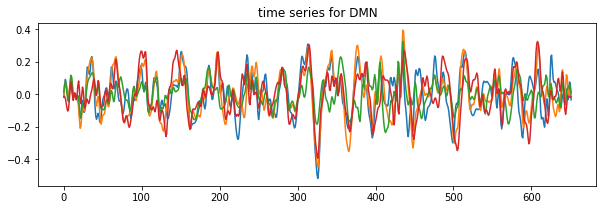

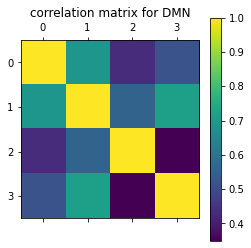

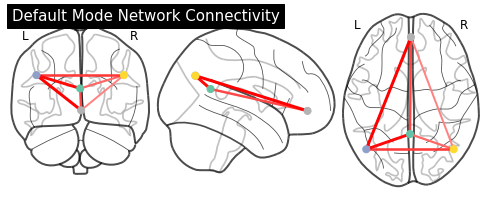

In [19]:
plt.figure(figsize=(10,3))
plt.plot(time_series)
plt.title('time series for DMN')
plt.show()

plt.matshow(f_conn_mat)
plt.colorbar()
plt.title('correlation matrix for DMN')
plt.show()


plot_connectome(f_conn_mat, list(dmn_coords.values()), title="Default Mode Network Connectivity")

### extracting connectivity and amplitude features for all the subjects

In [20]:
neuro_df_list = []
masker, labels = get_network_masker(dmn_coords)
net_name = 'DMN'

for s in sbj_list[:]:

    print('----- {0} -----'.format(s))

    sbj_frmi_path = fmri_path+'{0}_ses-01_task-rest_acq-AP_run-01_MNI2mm.nii'.format(s)
    sbj_conf_path = conf_path+'{0}_ses-01_task-rest_acq-AP_run-01_confounds.txt'.format(s)
    func_img = image.load_img(sbj_frmi_path)
    conf = np.loadtxt(sbj_conf_path)

    time_series = masker.fit_transform(func_img, confounds=conf)
    fconn_feat_df_corr = extract_fconn_features(time_series, labels, net_name, conn_type='correlation')
    fconn_feat_df_part = extract_fconn_features(time_series, labels, net_name, conn_type='partial correlation')
    ampli_feat_df = extract_ampli_features(time_series, labels, net_name, ampli_type='hilbert')

    neuro_feat_df = pd.concat([fconn_feat_df_corr, fconn_feat_df_part, ampli_feat_df], axis=1)
    neuro_feat_df['sbj_id'] = s

    neuro_df_list.append(neuro_feat_df)


In [248]:
neuro_df = pd.concat(neuro_df_list).reset_index()
neuro_df = neuro_df.drop(columns='index')

In [249]:
neuro_df

,DMN_cor_mean,DMN_cor_std,DMN_cor_PCC_LTJ,DMN_cor_PCC_RTJ,DMN_cor_PCC_MPC,DMN_cor_LTJ_RTJ,DMN_cor_LTJ_MPC,DMN_cor_RTJ_MPC,DMN_par_mean,DMN_par_std,...,DMN_amp_tot_std,DMN_amp_mean_PCC,DMN_amp_mean_LTJ,DMN_amp_mean_RTJ,DMN_amp_mean_MPC,DMN_amp_max_PCC,DMN_amp_max_LTJ,DMN_amp_max_RTJ,DMN_amp_max_MPC,sbj_id
0,0.407872,0.261518,0.692083,0.431609,0.516997,0.555256,0.717733,0.349298,0.181371,0.235337,...,0.071613,0.114824,0.122432,0.082408,0.119924,0.519814,0.481011,0.341586,0.431081,sub-032485
1,0.420699,0.253311,0.391972,0.634359,0.640674,0.545866,0.589883,0.562838,0.201672,0.224530,...,0.075058,0.147261,0.122372,0.123077,0.104850,0.520835,0.314425,0.350189,0.368707,sub-032449
2,0.465980,0.273962,0.591387,0.657476,0.735059,0.580677,0.608694,0.554548,0.207097,0.182748,...,0.078054,0.140951,0.107592,0.099208,0.124722,0.543646,0.317108,0.287150,0.427763,sub-032362
3,0.458612,0.298873,0.757956,0.539319,0.810929,0.599026,0.643625,0.318045,0.199829,0.277838,...,0.102679,0.186406,0.152359,0.107029,0.172060,0.565919,0.468023,0.335232,0.605687,sub-032344
4,0.373600,0.225205,0.441608,0.438580,0.549315,0.636073,0.496793,0.426432,0.190487,0.174069,...,0.086533,0.134105,0.132415,0.115615,0.136681,0.511346,0.471664,0.362931,0.647510,sub-032470
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
102,0.503914,0.300746,0.627321,0.812003,0.721132,0.635146,0.530648,0.705063,0.207965,0.170758,...,0.094473,0.167753,0.113134,0.123161,0.160346,0.545182,0.454676,0.353137,0.539997,sub-032368
103,0.486203,0.300865,0.691234,0.733595,0.725653,0.783993,0.508942,0.446206,0.213165,0.290173,...,0.076456,0.146740,0.115800,0.121086,0.093440,0.522868,0.316872,0.359672,0.295576,sub-032436
104,0.508101,0.314185,0.772013,0.601359,0.841940,0.585340,0.785149,0.479006,0.210304,0.241793,...,0.106142,0.163092,0.163928,0.092746,0.159853,0.618152,0.521216,0.221674,0.562449,sub-032377
105,0.398771,0.303060,0.683989,0.410077,0.721118,0.731665,0.554720,0.088603,0.202207,0.385715,...,0.088364,0.163137,0.146008,0.135311,0.113779,0.552149,0.502676,0.429888,0.399491,sub-032369


### saving features tables

In [250]:
save_path = '/Users/giovanni/Documents/Datasets/LEMON/processed/'
neuro_df.to_json(save_path+'LEMON_fmri_rs_features_{0}_complete.json'.format(net_name))